<a href="https://colab.research.google.com/github/Shreyash54/HealthMisinfoDetection/blob/main/SEM7_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install -U tf_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tf_geometric: filename=tf_geometric-0.1.6-py3-none-any.whl size=105906 sha256=490dfa2670df4f0ee0531e74601e6161ec943e825519983db84b49ed47b55d80
  Stored in directory: /root/.cache/pip/wheels/72/7b/70/345b56b708943397cd0df27b8222f8132e53635282db44dbd2
  Created wheel for ogb_lite: filename=ogb_lite-0.0.3-py3-none-any.whl size=33505 sha256=6a9704f13bce07321b2367ec204b4fc260913366be0e45c8eddd99161aaa1497
  Stored in directory: /root/.cache/pip/wheels/2b/0e/b0/3723bffa4b086fba81fe290d9651cffee49c1b565dc51e6dec
  Created wheel for tf_sparse: filename=tf_sparse-0.0.17-py3-none-any.whl size=21256 sha256=06dc3ed72f7008197d64127005dcd3175e4f561334cc80d808a20b0fcab07bbe
  Stored in directory: /root/.cache/pip/wheels/e9/6d/cd/f1715784c8fe

In [4]:

import os
from tf_geometric.utils import tf_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# # In case of any corpus are missing
# download all-nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
import tensorflow as tf
import tf_geometric as tfg
import pickle
import re
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data = pd.read_csv('/content/drive/MyDrive/HEALTH ASSURED/cleaned_dataset.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:

data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,statement,description,rating
0,6771.0,Dawn dish soap contains ammonia even though it...,Could Mixing Dawn Dish Soap with Clorox Bleach...,True
1,2468.0,Is blue light harmful to our eyes?,It seems reasonable to reduce exposure to blue...,True
2,1929.0,Are the 'Winter Blues' real?,"I've recently <a href=""https://www.sciencedail...",True
3,1872.0,Is air pollution linked to greater risk of dem...,"<a href=""https://www.theguardian.com/environme...",True
4,1956.0,Can eccentric exercises cause human hyperplasia?,With concentric regular exercises muscle hyper...,True


In [7]:
data.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id              0
statement       0
description    13
rating          0
dtype: int64

In [8]:
df = data.dropna(subset=["description"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id             0
statement      0
description    0
rating         0
dtype: int64

In [10]:

def clean_text(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  x = re.sub('rt','',x)
  return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:

data['statement'] = data['statement'].apply(clean_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data['statement'][0]


texts = data['statement']
print(texts.shape)
labels = data['rating']
print(labels.shape)
train_texts,test_texts,train_labels,test_labels = train_test_split(texts,labels)


(683,)
(683,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
print(train_texts.shape)
print(test_texts.shape)
print(train_labels.shape)
print(test_labels.shape)

(512,)
(171,)
(512,)
(171,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: ylabel='count'>

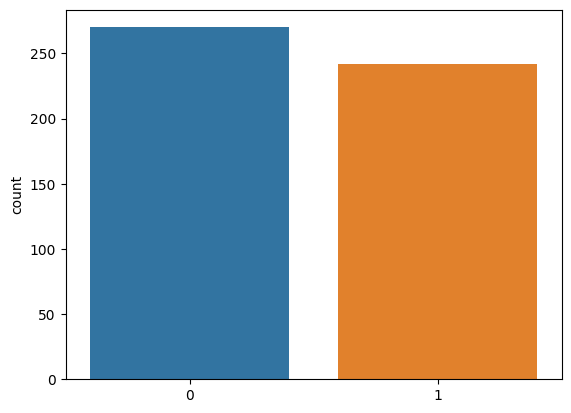

In [15]:
from sklearn.preprocessing import LabelEncoder
encoder =LabelEncoder()

train_labels= encoder.fit_transform(train_labels)
test_labels = encoder.transform(test_labels)
sns.countplot(x=train_labels)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:

class PMIModel(object):

    def __init__(self):
        self.word_counter = None
        self.pair_counter = None

    def get_pair_id(self, word0, word1):
        pair_id = tuple(sorted([word0, word1]))
        return pair_id

    def fit(self, sequences, window_size):

        self.word_counter = Counter()
        self.pair_counter = Counter()
        num_windows = 0
        for sequence in tqdm(sequences):
            for offset in range(len(sequence) - window_size):
                window = sequence[offset:offset + window_size]
                num_windows += 1
                for i, word0 in enumerate(window):
                    self.word_counter[word0] += 1
                    for j, word1 in enumerate(window[i + 1:]):
                        pair_id = self.get_pair_id(word0, word1)
                        self.pair_counter[pair_id] += 1

        for word, count in self.word_counter.items():
            self.word_counter[word] = count / num_windows
        for pair_id, count in self.pair_counter.items():
            self.pair_counter[pair_id] = count / num_windows

    def transform(self, word0, word1):
        prob_a = self.word_counter[word0]
        prob_b = self.word_counter[word1]
        pair_id = self.get_pair_id(word0, word1)
        prob_pair = self.pair_counter[pair_id]

        if prob_a == 0 or prob_b == 0 or prob_pair == 0:
           return 0

        pmi = np.log(prob_pair / (prob_a * prob_b))
        # print(word0, word1, pmi)
        pmi = np.maximum(pmi, 0.0)
        # print(pmi)
        return pmi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:

def build_word_graph(num_words, pmi_model, embedding_size):
    x = tf.Variable(tf.random.truncated_normal([num_words, embedding_size], stddev=1 / np.sqrt(embedding_size)),
                    dtype=tf.float32)
    edges = []
    edge_weight = []
    for (word0, word1) in pmi_model.pair_counter.keys():
        pmi = pmi_model.transform(word0, word1)
        if pmi > 0:
            edges.append([word0, word1])
            edge_weight.append(pmi)
            edges.append([word1, word0])
            edge_weight.append(pmi)
    edge_index = np.array(edges).T
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:

def build_combined_graph(word_graph, sequences, embedding_size):
    num_words = word_graph.num_nodes
    x = tf.zeros([len(sequences), embedding_size], dtype=tf.float32)
    edges = []
    edge_weight = []
    for i, sequence in enumerate(sequences):
        doc_node_index = num_words + i
        for word in sequence:
            edges.append([doc_node_index, word])  # only directed edge
            edge_weight.append(1.0)  # use BOW instaead of TF-IDF

    edge_index = np.array(edges).T
    x = tf.concat([word_graph.x, x], axis=0)
    edge_index = np.concatenate([word_graph.edge_index, edge_index], axis=1)
    edge_weight = np.concatenate([word_graph.edge_weight, edge_weight], axis=0)
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
pmi_cache_path = "cached_pmi_model.p"
if os.path.exists(pmi_cache_path):
    with open(pmi_cache_path, "rb") as f:
        pmi_model = pickle.load(f)
else:
    pmi_model = PMIModel()
    pmi_model.fit(train_sequences, window_size=6)
    with open(pmi_cache_path, "wb") as f:
        pickle.dump(pmi_model, f)

embedding_size = 150
num_words = len(tokenizer.word_index) + 1
word_graph = build_word_graph(num_words, pmi_model, embedding_size)
train_combined_graph = build_combined_graph(word_graph, train_sequences, embedding_size)
test_combined_graph = build_combined_graph(word_graph, test_sequences, embedding_size)

print(word_graph)
print(train_combined_graph)
print(test_combined_graph)

num_classes =4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 512/512 [00:00<00:00, 3559.74it/s]


Graph Shape: x => (1895, 150)	edge_index => (2, 16978)	y => None
Graph Shape: x => (2407, 150)	edge_index => (2, 21187)	y => None
Graph Shape: x => (2066, 150)	edge_index => (2, 17800)	y => None


In [21]:
class GCNModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(150, activation=tf.nn.relu)
        self.gcn1 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn2 = tfg.layers.GCN(50, activation=tf.nn.relu)
        self.gcn3 = tfg.layers.GCN(num_classes)
        self.dropout = keras.layers.Dropout(0.5)

    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], cache=cache)
        h = self.gcn1([h, edge_index, edge_weight], cache=cache)
        h = self.dropout(h, training=training)
        h = self.gcn2([h, edge_index, edge_weight], cache=cache)
        h = self.gcn3([h, edge_index, edge_weight], cache=cache)
        return h

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
model = GCNModel()
model.gcn0.cache_normed_edge(train_combined_graph)
model.gcn0.cache_normed_edge(test_combined_graph)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tf_geometric/layers/conv/gcn.py:126: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/tf_geometric/layers/conv/gcn.py:126: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, 

In [23]:
@tf_utils.function
def forward(graph, training=False):
    logits = model([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache, training=training)
    logits = logits[num_words:]
    return logits

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
def compute_loss(logits, labels):
    losses = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits,
        labels=tf.one_hot(labels,depth=num_classes)
    )
    mean_loss = tf.reduce_mean(losses)
    return mean_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
train_losses, train_accs, test_losses, test_accs= [],[],[],[]
for step in range(500):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)

    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step == 2500:
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    if step % 10 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, train_labels), tf.float32)
        train_accuracy = tf.reduce_mean(corrects)
        train_accs.append(train_accuracy)
        train_losses.append(mean_loss)

        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, test_labels), tf.float32)
        accuracy = tf.reduce_mean(corrects)
        test_accs.append(accuracy)
        test_losses.append(test_loss)
        print("step = {}\tloss = {}\ttrain_accuracy = {}\ttest_accuracy = {}".format(step, mean_loss, train_accuracy,accuracy))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step = 0	loss = 1.4083173274993896	train_accuracy = 0.443359375	test_accuracy = 0.5146198868751526
step = 10	loss = 0.7053244113922119	train_accuracy = 0.47265625	test_accuracy = 0.5146198868751526
step = 20	loss = 0.2952944040298462	train_accuracy = 0.880859375	test_accuracy = 0.6374269127845764
step = 30	loss = 0.2249208688735962	train_accuracy = 0.908203125	test_accuracy = 0.6549707651138306
step = 40	loss = 0.21164745092391968	train_accuracy = 0.916015625	test_accuracy = 0.6608186960220337
step = 50	loss = 0.14848288893699646	train_accuracy = 0.93359375	test_accuracy = 0.6666666865348816
step = 60	loss = 0.1226932480931282	train_accuracy = 0.943359375	test_accuracy = 0.6842105388641357
step = 70	loss = 0.1293032169342041	train_accuracy = 0.947265625	test_accuracy = 0.6842105388641357
step = 80	loss = 0.09001628309488297	train_accuracy = 0.9609375	test_accuracy = 0.6783625483512878
step = 90	loss = 0.13730654120445251	train_accuracy = 0.9609375	test_accuracy = 0.6900584697723389
ste

In [26]:

print("Best Training Accuracy - " ,max(np.array(test_accs))*100)



Best Training Accuracy -  69.59064602851868


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, preds)

# Calculate F1 score
f1 = f1_score(test_labels, preds, average='weighted')  # 'weighted' takes into account class imbalance

# Generate a classification report
report = classification_report(test_labels, preds)

# Print the metrics
print("Accuracy:", accuracy)
print("F1 Score (weighted):", f1)
print("Classification Report:")
print(report)



Accuracy: 0.6549707602339181
F1 Score (weighted): 0.6525517491704997
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        83
           1       0.70      0.57      0.63        88

    accuracy                           0.65       171
   macro avg       0.66      0.66      0.65       171
weighted avg       0.66      0.65      0.65       171



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


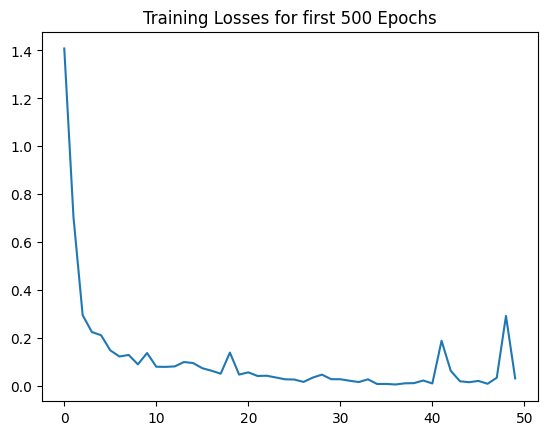

In [28]:
plt.plot(range(len(train_losses)),train_losses)
plt.title("Training Losses for first 500 Epochs")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


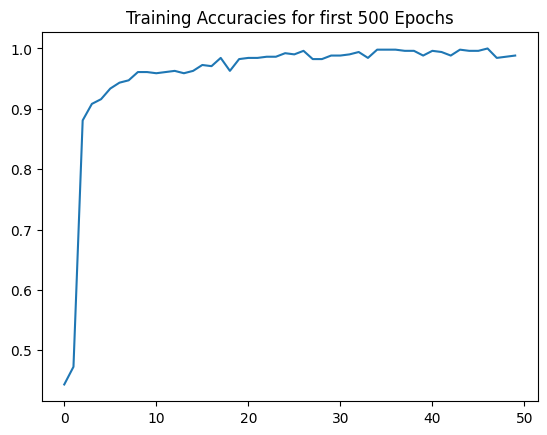

In [29]:
plt.plot(range(len(train_accs)),train_accs)
plt.title("Training Accuracies for first 500 Epochs")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


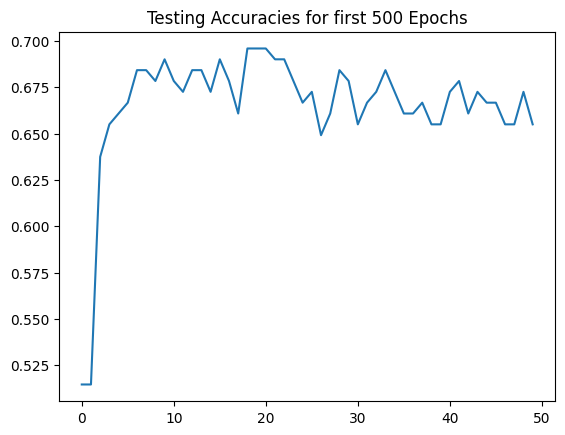

In [30]:
plt.plot(range(len(test_accs)),test_accs)
plt.title("Testing Accuracies for first 500 Epochs")
plt.show()


In [37]:

from sklearn.metrics import classification_report, accuracy_score, f1_score

# Assuming you have already calculated 'test_labels' and 'preds'

# Generate a classification report
report = classification_report(test_labels, preds, output_dict=True)

# Extract TP, TN, FP, FN for each class
class_names = [str(cls) for cls in report.keys() if cls != 'accuracy' and cls != 'macro avg' and cls != 'weighted avg']
metrics = report['0']  # Assuming you are interested in class '0' (modify as needed)

TP = metrics['precision'] * metrics['support']
FN = metrics['support'] - TP
FP = metrics['support'] / metrics['recall'] - TP
TN = metrics['support'] - (TP + FN + FP)

# Print the metrics for class '0'
print(f"True Positives (TP): {TP:.0f}")
print(f"False Negatives (FN): {FN:.0f}")
print(f"False Positives (FP): {FP:.0f}")
print(f"True Negatives (TN): {TN:.0f}")


True Positives (TP): 51
False Negatives (FN): 32
False Positives (FP): 60
True Negatives (TN): -60


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


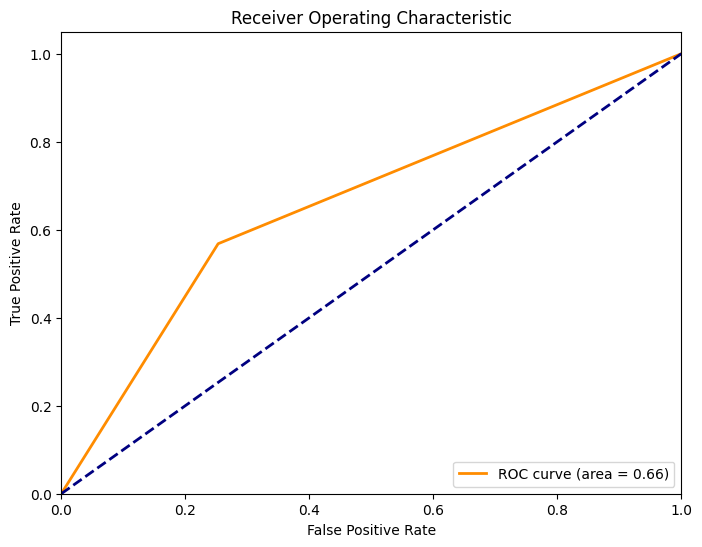

AUC (Area Under the ROC Curve): 0.66


In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already calculated 'test_labels' and 'preds'

# Calculate the ROC AUC score
roc_auc = roc_auc_score(test_labels, preds)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(test_labels, preds)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f"AUC (Area Under the ROC Curve): {roc_auc:.2f}")
